# Spark environment

In [2]:
import pandas as pd
import numpy as np
import math
import os
import datetime
import matplotlib.pyplot as plt
import findspark
import pyspark.sql.functions as f
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import split, col
from pyspark.sql.functions import size
from pyspark.sql.functions import col,lit
from pyspark.sql import DataFrame
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Phrases
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)
%matplotlib inline

In [219]:
home = os.environ["HOME"]

D1 = "/.local/lib/python3.9/site-packages/pyspark"
D2 = "/root/anaconda3/lib/python3.9/site-packages/pyspark"

if os.path.exists(D1):
    os.environ["SPARK_HOME"] = home +  D1
elif os.path.exists(D2):
    os.environ["SPARK_HOME"] = home +  D2
else:
    print("PB de path")

os.environ["JAVA_HOME"] ="/usr"

PB de path


### Start spark 

In [220]:
import findspark 
print("findspark.init() initialise les variables d'environnement pour spark") 
findspark.init() 

from pyspark.sql import SparkSession 
from pyspark import SparkConf  
from pyspark.sql.types import *

findspark.init() initialise les variables d'environnement pour spark


In [221]:
def demarrer_spark():
    local = "local[*]"
    appName = "TP"
    configLocale = SparkConf().setAppName(appName).setMaster(local).\
    set("spark.executor.memory", "100G").\
    set("spark.driver.memory","50G").\
    set("spark.sql.catalogImplementation","in-memory").\
    set("spark.driver.maxResultSize", "10G")

    spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("ERROR")

    # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
    # spark.conf.set("spark.sql.shuffle.partitions","200")    

    print("session démarrée, son id est ", sc.applicationId)
    return spark

    spark = demarrer_spark()

session démarrée, son id est  local-1673615628852


###  SQL Magic

In [222]:
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)

def removeComments(query):
    result = ""
    for line in query.split('\n'):
    if not(line.strip().startswith("--")):
      result += line + "\n"
    return result

@register_line_cell_magic
def sql(line, cell=None):
    "To run a sql query. Use:  %%sql"
    val = cell if cell is not None else line
    tabRequetes = removeComments(val).split(";")
    derniere = None
    est_requete = False
    for r in tabRequetes:
        r = r.strip()
        if len(r) > 2:
          derniere = spark.sql(r)
          est_requete = r.lower().startswith('select') or r.lower().startswith('with')  
    if(est_requete):
        return display(derniere)
    else:
        return print('ok')

display

In [223]:
def display(df, n=10):
    pd.set_option('max_columns', None)
    pd.set_option('max_colwidth', None)
    return df.limit(n).toPandas()

print("display redéfini")

display redéfini


### figure storage folder

In [224]:
notebook_dir = "/home/jarrad/Bureau/notebook_sara/figures/"
numero_experience = "eperience_tous_maillage/"

# Dataset with embeddings

In [269]:
# Read the file containing the results with embeddings (MRR cos and JACCARD cos) 
# /home/jarrad/Bureau/notebook_sara/experiment/expe_148_vectors.csv :  the path to the file where the results are stored
fichiers_avec_toutes_les_experiences_avec_embeddings = pd.read_csv('/home/jarrad/Bureau/notebook_sara/experiment/expe_148_vectors.csv')
fichiers_avec_toutes_les_experiences_avec_embeddings

,maillage,k,dimension,epoch,fonction de similarite,qualite
0,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277
1,10,5,25,100,similarite_trajectoires_MRR_cosinus,0.634043
2,10,7,25,100,similarite_trajectoires_MRR_cosinus,0.642553
3,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809
4,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809
...,...,...,...,...,...,...
127,500,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.255233
128,500,7,25,100,similarite_trajectoires_JACCARD_cosinus,0.269726
129,500,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.275094
130,500,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.273752


In [270]:
# Rename dataframe's columns
fichiers_avec_toutes_les_experiences_avec_embeddings_spark = spark.createDataFrame(fichiers_avec_toutes_les_experiences_avec_embeddings).withColumnRenamed("qualite","qualite_avec_embeddings").withColumnRenamed("fonction de similarite","fonction_similarite_avec_embeddings")
display(fichiers_avec_toutes_les_experiences_avec_embeddings_spark, 10)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings
0,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277
1,10,5,25,100,similarite_trajectoires_MRR_cosinus,0.634043
2,10,7,25,100,similarite_trajectoires_MRR_cosinus,0.642553
3,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809
4,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809
5,10,20,25,100,similarite_trajectoires_MRR_cosinus,0.646809
6,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298
7,10,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.659574
8,10,7,25,100,similarite_trajectoires_JACCARD_cosinus,0.663830
9,10,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.672340


# Dataset without embeddings

In [271]:
# Read the file containing the results without embeddings (MRR and JACCARD) 
# /home/jarrad/Bureau/notebook_sara/experiment/expe_148_no_vectors.csv :  the path to the file where the results are stored
fichiers_avec_toutes_les_experiences_sans_embeddings = pd.read_csv('/home/jarrad/Bureau/notebook_sara/experiment/expe_148_no_vectors.csv')
fichiers_avec_toutes_les_experiences_sans_embeddings.head(5)

,maillage,k,dimension,epoch,fonction de similarite,qualite
0,10,2,0,0,similarite_trajectoires_JACCARD,0.646809
1,10,5,0,0,similarite_trajectoires_JACCARD,0.668085
2,10,7,0,0,similarite_trajectoires_JACCARD,0.672340
3,10,10,0,0,similarite_trajectoires_JACCARD,0.680851
4,10,15,0,0,similarite_trajectoires_JACCARD,0.680851


In [272]:
fichiers_avec_toutes_les_experiences_sans_embeddings_spark = spark.createDataFrame(fichiers_avec_toutes_les_experiences_sans_embeddings).withColumnRenamed("fonction de similarite","fonction_similarite_sans_embeddings").withColumnRenamed("qualite","qualite_sans_embeddings")
display(fichiers_avec_toutes_les_experiences_sans_embeddings_spark, 5)

,maillage,k,dimension,epoch,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,10,2,0,0,similarite_trajectoires_JACCARD,0.646809
1,10,5,0,0,similarite_trajectoires_JACCARD,0.668085
2,10,7,0,0,similarite_trajectoires_JACCARD,0.672340
3,10,10,0,0,similarite_trajectoires_JACCARD,0.680851
4,10,15,0,0,similarite_trajectoires_JACCARD,0.680851


# Join with/without embeddings tables

In [273]:
# Join between tables with /without embeddings
def jointure_table_avec_sans_embeddings(table_avec_embeddings, table_sans_embeddings):
    table_avec_embeddings.createOrReplaceTempView("table_avec_embeddings")
    table_sans_embeddings.createOrReplaceTempView("table_sans_embeddings")
    
    query = """
            select  a.*, s.fonction_similarite_sans_embeddings, s.qualite_sans_embeddings
            from table_avec_embeddings a , table_sans_embeddings s
            where s.k = a.k and s.maillage=a.maillage
            order by k

            
            """
    return spark.sql(query)

In [274]:
jointure =jointure_table_avec_sans_embeddings(fichiers_avec_toutes_les_experiences_avec_embeddings_spark, fichiers_avec_toutes_les_experiences_sans_embeddings_spark)
display(jointure,5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,20,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.496042,similarite_trajectoires_JACCARD,0.493404
1,20,2,25,100,similarite_trajectoires_MRR_cosinus,0.498681,similarite_trajectoires_JACCARD,0.493404
2,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298,similarite_trajectoires_MRR,0.629787
3,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298,similarite_trajectoires_JACCARD,0.646809
4,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277,similarite_trajectoires_JACCARD,0.646809


##  JACCARD/ JACCARD cos table

In [275]:
# Filtering on the data (keep the results of the JACCARD and JACCARD cos functions)
def table_sim_jaccard(table_experience):
    table_experience.createOrReplaceTempView("table_experience")
    
    
    query = """

            select *
            from table_experience
            where fonction_similarite_sans_embeddings = "similarite_trajectoires_JACCARD"
            and fonction_similarite_avec_embeddings = "similarite_trajectoires_JACCARD_cosinus"
            order by maillage, k, dimension, epoch
    
            
            
            """
    return spark.sql(query)

In [276]:
qualite_avec_jaccard = table_sim_jaccard(jointure)
display(qualite_avec_jaccard,5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298,similarite_trajectoires_JACCARD,0.646809
1,10,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.659574,similarite_trajectoires_JACCARD,0.668085
2,10,7,25,100,similarite_trajectoires_JACCARD_cosinus,0.663830,similarite_trajectoires_JACCARD,0.672340
3,10,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.672340,similarite_trajectoires_JACCARD,0.680851
4,10,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851


## MRR/ MRR cos table

In [277]:
# Filtering on the data (keep the results of the MRR and MRR cos functions)
def table_sim_MRR(table_des_experience):
    table_des_experience.createOrReplaceTempView("table_des_experience")
    
    
    query = """

            select *
            from table_des_experience
            where fonction_similarite_sans_embeddings = "similarite_trajectoires_MRR"
            and fonction_similarite_avec_embeddings = "similarite_trajectoires_MRR_cosinus"
            order by maillage, k, dimension, epoch
    
            
            
            """
    return spark.sql(query)

In [278]:
qualite_avec_MRR = table_sim_MRR(jointure)
display(qualite_avec_MRR, 5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277,similarite_trajectoires_MRR,0.629787
1,10,5,25,100,similarite_trajectoires_MRR_cosinus,0.634043,similarite_trajectoires_MRR,0.646809
2,10,7,25,100,similarite_trajectoires_MRR_cosinus,0.642553,similarite_trajectoires_MRR,0.646809
3,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809
4,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809


# Qualities / Benefits JACCARD vs. JACCARD cos

## Quality JACCARD-JACCARDS cosinus

### min/max quality value JACCARD vs JACCARD cos

In [279]:
def qualite_max_jaccard(table_de_qualite):
    table_de_qualite.createOrReplaceTempView("table_de_qualite")
    
    
    query = """

            select max(qualite_avec_embeddings) as qualite_avec_embeddings_max,
                    max(qualite_sans_embeddings) as qualite_sans_embeddings_max
         
            from table_de_qualite 

    
            
            
            """
    return spark.sql(query)

In [280]:
qualite_max_tab = qualite_max_jaccard(qualite_avec_jaccard)
display(qualite_max_tab)

,qualite_avec_embeddings_max,qualite_sans_embeddings_max
0,0.676596,0.680851


### Optimal combination to achieve JACCARD cos max quality

In [281]:
def jointure_table_qualite_qualitemax(table_qualite, table_qualite_max):
    table_qualite.createOrReplaceTempView("table_qualite")
    table_qualite_max.createOrReplaceTempView("table_qualite_max")
    
    query = """
            select  b.*
            from table_qualite b , table_qualite_max m
            where b.qualite_avec_embeddings = m.qualite_avec_embeddings_max 

            
            """
    return spark.sql(query)

In [282]:
display(jointure_table_qualite_qualitemax(qualite_avec_jaccard,qualite_max_tab))

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,10,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851
1,10,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851


### best quality for JACCARD with/without embeddings by mesh

In [283]:
def meilleure_qualite_selon_maillage(table_qualite_by_maillage):
    table_qualite_by_maillage.createOrReplaceTempView("table_qualite_by_maillage")

    
    query = """
            select  maillage, max(qualite_avec_embeddings) as meilleur_qualite_avec_embeddings 
            from table_qualite_by_maillage
            group by maillage 
            order by  meilleur_qualite_avec_embeddings

            
            """
    return spark.sql(query)

In [284]:
meilleure_qualite_regrouper_par_maillage = meilleure_qualite_selon_maillage(qualite_avec_jaccard)
display(meilleure_qualite_regrouper_par_maillage, 20)

,maillage,meilleur_qualite_avec_embeddings
0,500,0.275094
1,400,0.281830
2,200,0.305840
3,150,0.312604
4,70,0.329588
5,100,0.337178
6,50,0.358371
7,40,0.378911
8,30,0.447917
9,20,0.538259


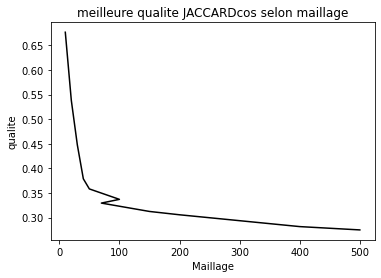

In [285]:
meilleure_qualite_regrouper_par_maillage_pandas = meilleure_qualite_regrouper_par_maillage.toPandas()
x = meilleure_qualite_regrouper_par_maillage_pandas["maillage"]
y = meilleure_qualite_regrouper_par_maillage_pandas["meilleur_qualite_avec_embeddings"]
plt.plot(x, y, 'k')
plt.title('meilleure qualite JACCARDcos selon maillage')
plt.xlabel('Maillage')
plt.ylabel('qualite')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "meilleure_qualite_par_maillage.png")
plt.show()

## Benefits of JACCARD-JACCARDS cosinus

In [286]:
def table_benefice_JACCARD_JACCARDcos(table_qualites):
    table_qualites.createOrReplaceTempView("table_qualites")
    
    
    query = """

            select maillage, k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings, ((qualite_avec_embeddings / qualite_sans_embeddings) -1)*100 as benefice_JACCARD_JACCARDcos 
         
            from table_qualites 

    
            
            
            """
    return spark.sql(query)

In [287]:
table_benefice_Jaccard_Jaccardcos = table_benefice_JACCARD_JACCARDcos(qualite_avec_jaccard)
display(table_benefice_Jaccard_Jaccardcos, 5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298,similarite_trajectoires_JACCARD,0.646809,-1.315789
1,10,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.659574,similarite_trajectoires_JACCARD,0.668085,-1.273885
2,10,7,25,100,similarite_trajectoires_JACCARD_cosinus,0.663830,similarite_trajectoires_JACCARD,0.672340,-1.265823
3,10,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.672340,similarite_trajectoires_JACCARD,0.680851,-1.250000
4,10,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851,-0.625000


In [288]:
def round_6_benefice(table_benefices):
    table_benefices.createOrReplaceTempView("table_benefices")
    
    
    
    query = """

            select maillage, k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings,
            round(benefice_JACCARD_JACCARDcos, 6) 
         
            from table_benefices

    
            
            
            """
    return spark.sql(query)

In [289]:
round_benefice_JACCARD = round_6_benefice(table_benefice_Jaccard_Jaccardcos).withColumnRenamed("round(benefice_JACCARD_JACCARDcos, 6)","benefice_JACCARD_JACCARDcos")
display(round_benefice_JACCARD, 5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,10,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.638298,similarite_trajectoires_JACCARD,0.646809,-1.315789
1,10,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.659574,similarite_trajectoires_JACCARD,0.668085,-1.273885
2,10,7,25,100,similarite_trajectoires_JACCARD_cosinus,0.663830,similarite_trajectoires_JACCARD,0.672340,-1.265823
3,10,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.672340,similarite_trajectoires_JACCARD,0.680851,-1.250000
4,10,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851,-0.625000


### min/max benefit value for JACCARD by mesh

In [290]:
def table_Jaccard_Jaccardcos(table_des_benefices):
    table_des_benefices.createOrReplaceTempView("table_des_benefices")
    
    
    query = """

            select maillage, min(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_min, max(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_max,
                    avg(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_moyen
         
            from table_des_benefices 
            group by maillage
            order by maillage

    
            
            
            """
    return spark.sql(query)

In [291]:
min_max_benefice_Jaccard_Jaccardcos = table_Jaccard_Jaccardcos(round_benefice_JACCARD)
display(min_max_benefice_Jaccard_Jaccardcos, 20)

,maillage,benefice_JACCARD_JACCARDcos_min,benefice_JACCARD_JACCARDcos_max,benefice_JACCARD_JACCARDcos_moyen
0,10,-1.315789,-0.625000,-1.059249
1,20,0.502513,2.000000,0.932272
2,30,4.564315,6.172840,5.583323
3,40,0.719424,7.641196,4.708560
4,50,-2.915452,3.394256,1.100971
5,70,3.940887,11.252654,9.154402
6,100,-3.094463,5.128205,2.527583
7,150,-0.973574,7.664671,4.762333
8,200,0.662252,10.119695,7.344447
9,400,-4.083770,0.726612,-0.782891


### Optimal combination to achieve JACCARD cos max benefit

In [292]:
def jointure_table_benefice_beneficemax(table_benefice, table_benefice_max):
    table_benefice.createOrReplaceTempView("table_benefice")
    table_benefice_max.createOrReplaceTempView("table_benefice_max")
    
    query = """
            select  b.*
            from table_benefice b , table_benefice_max m
            where b.benefice_JACCARD_JACCARDcos = m.benefice_JACCARD_JACCARDcos_max 
            order by maillage

            
            """
    return spark.sql(query)

In [293]:
combinaison_optimale_pour_meilleur_qualite_JACCARD_JACCARdcos = jointure_table_benefice_beneficemax(round_benefice_JACCARD, min_max_benefice_Jaccard_Jaccardcos)
display(combinaison_optimale_pour_meilleur_qualite_JACCARD_JACCARdcos, 20)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,10,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851,-0.625000
1,10,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851,-0.625000
2,20,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.538259,similarite_trajectoires_JACCARD,0.527704,2.000000
3,30,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.447917,similarite_trajectoires_JACCARD,0.421875,6.172840
4,40,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.375435,similarite_trajectoires_JACCARD,0.348783,7.641196
5,50,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.358371,similarite_trajectoires_JACCARD,0.346606,3.394256
6,70,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.327091,similarite_trajectoires_JACCARD,0.294007,11.252654
7,100,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.327418,similarite_trajectoires_JACCARD,0.311446,5.128205
8,150,10,25,100,similarite_trajectoires_JACCARD_cosinus,0.298969,similarite_trajectoires_JACCARD,0.277685,7.664671
9,200,15,25,100,similarite_trajectoires_JACCARD_cosinus,0.304636,similarite_trajectoires_JACCARD,0.276641,10.119695


# Qualities / Benefits MRR vs. MRR cos

## Quality MRR-MRR cosinus

### min/max quality value MRR vs MRR cos

In [294]:
def qualite_max_mrr(table_de_qualite_mrr):
    table_de_qualite_mrr.createOrReplaceTempView("table_de_qualite_mrr")
    
    
    query = """

            select max(qualite_avec_embeddings) as qualite_avec_embeddings_max,
                    max(qualite_sans_embeddings) as qualite_sans_embeddings_max
         
            from table_de_qualite_mrr 

    
            
            
            """
    return spark.sql(query)

In [295]:
qualite_max_mrr = qualite_max_mrr(qualite_avec_MRR)
display(qualite_max_mrr)

,qualite_avec_embeddings_max,qualite_sans_embeddings_max
0,0.646809,0.646809


### optimal Combinaison to achieve MRR cos max quality

In [296]:
def jointure_table_qualite_qualitemax_mrr(table_qualite_mrr, table_qualite_max_mrr):
    table_qualite_mrr.createOrReplaceTempView("table_qualite_mrr")
    table_qualite_max_mrr.createOrReplaceTempView("table_qualite_max_mrr")
    
    query = """
            select  b.*
            from table_qualite_mrr b , table_qualite_max_mrr m
            where b.qualite_avec_embeddings = m.qualite_avec_embeddings_max 

            
            """
    return spark.sql(query)

In [297]:
display(jointure_table_qualite_qualitemax_mrr(qualite_avec_MRR,qualite_max_mrr))

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809
1,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809
2,10,20,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809


### Best quality for MRR with/without embeddings by mesh

In [298]:
def meilleure_qualite_selon_maillage_mrr(table_qualite_by_maillage_mrr):
    table_qualite_by_maillage_mrr.createOrReplaceTempView("table_qualite_by_maillage_mrr")

    
    query = """
            select  maillage, max(qualite_avec_embeddings) as meilleur_qualite_avec_embeddings  
            from table_qualite_by_maillage_mrr
            group by maillage 
            order by  meilleur_qualite_avec_embeddings

            
            """
    return spark.sql(query)

In [299]:
meilleure_qualite_regrouper_par_maillage_mrr = meilleure_qualite_selon_maillage_mrr(qualite_avec_MRR)
display(meilleure_qualite_regrouper_par_maillage_mrr, 20)

,maillage,meilleur_qualite_avec_embeddings
0,500,0.272947
1,400,0.277255
2,200,0.301927
3,150,0.305620
4,70,0.327715
5,100,0.330080
6,50,0.354751
7,40,0.376593
8,30,0.439236
9,20,0.535620


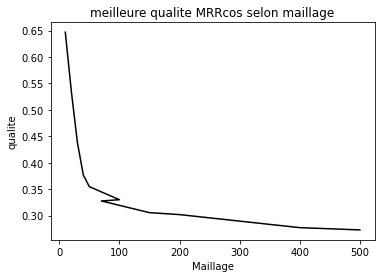

In [300]:
meilleure_qualite_regrouper_par_maillage_mrr_pandas = meilleure_qualite_regrouper_par_maillage_mrr.toPandas()
x = meilleure_qualite_regrouper_par_maillage_mrr_pandas["maillage"]
y = meilleure_qualite_regrouper_par_maillage_mrr_pandas["meilleur_qualite_avec_embeddings"]
plt.plot(x, y, 'k')
plt.title('meilleure qualite MRRcos selon maillage')
plt.xlabel('Maillage')
plt.ylabel('qualite')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "meilleure_qualite_par_maillage_MRRcos.png")
plt.show()

## Benefits of MRR-MRR cosinus

In [301]:
def table_benefice_MRR_MRRcos(table_qualites):
    table_qualites.createOrReplaceTempView("table_qualites")
    
    
    query = """

            select maillage,k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings, ((qualite_avec_embeddings / qualite_sans_embeddings) -1)*100 as benefice_MRR_MRRcos 
         
            from table_qualites 

    
            
            
            """
    return spark.sql(query)

In [302]:
table_benefice_MRR = table_benefice_MRR_MRRcos(qualite_avec_MRR)
display(table_benefice_MRR, 5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277,similarite_trajectoires_MRR,0.629787,-1.351351
1,10,5,25,100,similarite_trajectoires_MRR_cosinus,0.634043,similarite_trajectoires_MRR,0.646809,-1.973684
2,10,7,25,100,similarite_trajectoires_MRR_cosinus,0.642553,similarite_trajectoires_MRR,0.646809,-0.657895
3,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
4,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000


In [303]:
def round_6_benefice(table_benefices):
    table_benefices.createOrReplaceTempView("table_benefices")
    
    
    query = """

            select maillage, k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings,
            round(benefice_MRR_MRRcos, 6) 
         
            from table_benefices

    
            
            
            """
    return spark.sql(query)

In [304]:
round_benefice_MRR = round_6_benefice(table_benefice_MRR).withColumnRenamed("round(benefice_MRR_MRRcos, 6)","benefice_MRR_MRRcos")
display(round_benefice_MRR, 5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,10,2,25,100,similarite_trajectoires_MRR_cosinus,0.621277,similarite_trajectoires_MRR,0.629787,-1.351351
1,10,5,25,100,similarite_trajectoires_MRR_cosinus,0.634043,similarite_trajectoires_MRR,0.646809,-1.973684
2,10,7,25,100,similarite_trajectoires_MRR_cosinus,0.642553,similarite_trajectoires_MRR,0.646809,-0.657895
3,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
4,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000


### min/max benefit value for MRR by mesh

In [305]:
def table_Benefice_min_max_avg_MRR_MRRcos(table_benefice):
    table_benefice.createOrReplaceTempView("table_benefice")
    
    
    query = """

            select maillage, min(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_min, max(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_max,
                    avg(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_moyen
         
            from table_benefice
            group by maillage
            order by maillage

    
            
            
            """
    return spark.sql(query)

In [306]:
min_max_benefice_MRR_MRRcos= table_Benefice_min_max_avg_MRR_MRRcos(round_benefice_MRR)
display(min_max_benefice_MRR_MRRcos, 20)

,maillage,benefice_MRR_MRRcos_min,benefice_MRR_MRRcos_max,benefice_MRR_MRRcos_moyen
0,10,-1.973684,0.000000,-0.663822
1,20,-1.562500,3.571429,1.440264
2,30,-3.004292,6.302521,2.370433
3,40,-7.666667,7.260726,0.595841
4,50,-10.326087,2.617801,-2.548960
5,70,-18.164063,1.156069,-7.059529
6,100,-15.049226,1.500682,-4.637687
7,150,-18.574766,3.607666,-5.395837
8,200,-17.199559,5.801688,-2.451454
9,400,-10.717703,1.867414,-2.207158


### optimal combinaison to achieve MRR cos max benefit

In [307]:
def jointure_table_benefice_beneficemax(table_benefice_MRR, table_benefice_max_MRR):
    table_benefice_MRR.createOrReplaceTempView("table_benefice_MRR")
    table_benefice_max_MRR.createOrReplaceTempView("table_benefice_max_MRR")
    
    query = """
            select  b.*
            from table_benefice_MRR b , table_benefice_max_MRR m
            where b.benefice_MRR_MRRcos = m.benefice_MRR_MRRcos_max 
            order by maillage

            
            """
    return spark.sql(query)

In [308]:
combinaison_optimale_pour_meilleur_qualite_MRR_MRRcos = jointure_table_benefice_beneficemax(round_benefice_MRR, min_max_benefice_MRR_MRRcos)
display(combinaison_optimale_pour_meilleur_qualite_MRR_MRRcos)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,10,15,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
1,10,10,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
2,10,20,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
3,20,15,25,100,similarite_trajectoires_MRR_cosinus,0.535620,similarite_trajectoires_MRR,0.517150,3.571429
4,20,20,25,100,similarite_trajectoires_MRR_cosinus,0.535620,similarite_trajectoires_MRR,0.517150,3.571429
5,30,20,25,100,similarite_trajectoires_MRR_cosinus,0.439236,similarite_trajectoires_MRR,0.413194,6.302521
6,30,5,25,100,similarite_trajectoires_MRR_cosinus,0.413194,similarite_trajectoires_MRR,0.413194,0.000000
7,40,20,25,100,similarite_trajectoires_MRR_cosinus,0.376593,similarite_trajectoires_MRR,0.351101,7.260726
8,50,20,25,100,similarite_trajectoires_MRR_cosinus,0.354751,similarite_trajectoires_MRR,0.345701,2.617801
9,70,20,25,100,similarite_trajectoires_MRR_cosinus,0.327715,similarite_trajectoires_MRR,0.323970,1.156069


## Curves

### Benefit with fixed k, dimension, epoch, and variable mesh size

#### MRR-MRRcos (dimension = 25, k=20, et epoch=100)

In [309]:
benefice_MRR_k_50 = round_benefice_MRR.where("k=20")
display(benefice_MRR_k_50,20)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,10,20,25,100,similarite_trajectoires_MRR_cosinus,0.646809,similarite_trajectoires_MRR,0.646809,0.000000
1,20,20,25,100,similarite_trajectoires_MRR_cosinus,0.535620,similarite_trajectoires_MRR,0.517150,3.571429
2,30,20,25,100,similarite_trajectoires_MRR_cosinus,0.439236,similarite_trajectoires_MRR,0.413194,6.302521
3,40,20,25,100,similarite_trajectoires_MRR_cosinus,0.376593,similarite_trajectoires_MRR,0.351101,7.260726
4,50,20,25,100,similarite_trajectoires_MRR_cosinus,0.354751,similarite_trajectoires_MRR,0.345701,2.617801
5,70,20,25,100,similarite_trajectoires_MRR_cosinus,0.327715,similarite_trajectoires_MRR,0.323970,1.156069
6,100,20,25,100,similarite_trajectoires_MRR_cosinus,0.330080,similarite_trajectoires_MRR,0.325200,1.500682
7,150,20,25,100,similarite_trajectoires_MRR_cosinus,0.305620,similarite_trajectoires_MRR,0.294978,3.607666
8,200,20,25,100,similarite_trajectoires_MRR_cosinus,0.301927,similarite_trajectoires_MRR,0.285370,5.801688
9,400,20,25,100,similarite_trajectoires_MRR_cosinus,0.277255,similarite_trajectoires_MRR,0.272173,1.867414


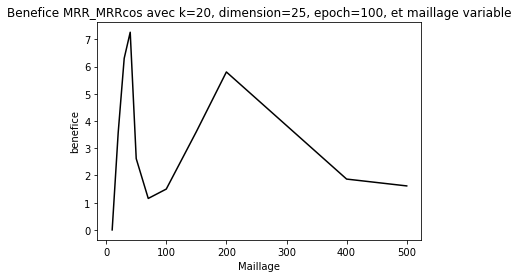

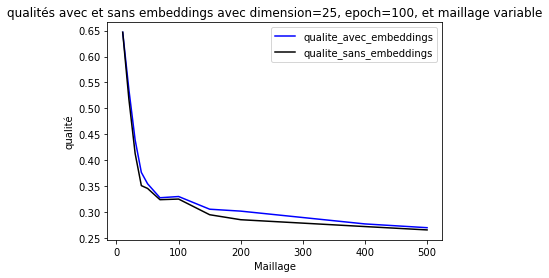

In [310]:
benefice_MRR_k_50_pandas = benefice_MRR_k_50.toPandas()
x = benefice_MRR_k_50_pandas["maillage"]
y = benefice_MRR_k_50_pandas["benefice_MRR_MRRcos"]
plt.plot(x, y, 'k')
plt.title('Benefice MRR_MRRcos avec k=20, dimension=25, epoch=100, et maillage variable')
plt.xlabel('Maillage')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_MRRcos_k20_epoch100_dimension25_maillage_variable.png")
plt.show()


x = benefice_MRR_k_50_pandas["maillage"]
y1 = benefice_MRR_k_50_pandas["qualite_avec_embeddings"]
y2 = benefice_MRR_k_50_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, 'b', label="qualite_avec_embeddings")
plt.plot(x, y2, 'k', label="qualite_sans_embeddings")
plt.title('qualités avec et sans embeddings avec dimension=25, epoch=100, et maillage variable')

axes = plt.gca()
axes.set_xlabel('Maillage')
axes.set_ylabel('qualité')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_MRRcos_k20_epoch100_dimension25_maillage_variable.png")
plt.show()

#### JACCARD-JACCARDcos (dimension = 25, k=15, et epoch=100)

In [311]:
benefice_JACCARD_k_15 = round_benefice_JACCARD.where("k=20")
display(benefice_JACCARD_k_15,5)

,maillage,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,10,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.676596,similarite_trajectoires_JACCARD,0.680851,-0.625000
1,20,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.538259,similarite_trajectoires_JACCARD,0.527704,2.000000
2,30,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.447917,similarite_trajectoires_JACCARD,0.421875,6.172840
3,40,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.378911,similarite_trajectoires_JACCARD,0.356895,6.168831
4,50,20,25,100,similarite_trajectoires_JACCARD_cosinus,0.358371,similarite_trajectoires_JACCARD,0.346606,3.394256


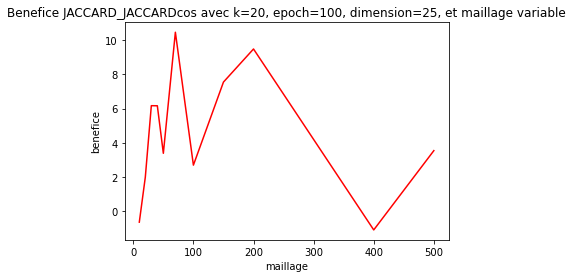

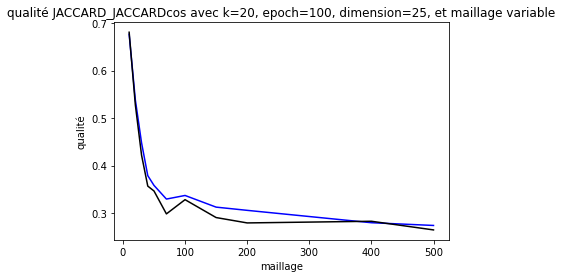

In [313]:
benefice_JACCARD_k_15_pandas = benefice_JACCARD_k_15.toPandas()
x = benefice_JACCARD_k_15_pandas["maillage"]
y = benefice_JACCARD_k_15_pandas["benefice_JACCARD_JACCARDcos"]
plt.plot(x, y, 'r')
plt.title('Benefice JACCARD_JACCARDcos avec k=20, epoch=100, dimension=25, et maillage variable')
plt.xlabel('maillage')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_JACCARDcos_k20_epoch100_dimension25_maillage_variable.png")
plt.show()

x = benefice_JACCARD_k_15_pandas["maillage"]
y1 = benefice_JACCARD_k_15_pandas["qualite_avec_embeddings"]
y2 = benefice_JACCARD_k_15_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'k')
plt.title('qualité JACCARD_JACCARDcos avec k=20, epoch=100, dimension=25, et maillage variable')
axes = plt.gca()
axes.set_xlabel('maillage')
axes.set_ylabel('qualité')
plt.savefig(notebook_dir + numero_experience + "qualite_JACCARDcos_k20_epoch100_dimension25_maillage_variable.png")
plt.show()

### Best quality with/without embeddings depending on the mesh size

In [3]:
#df2 constructed through the JACCARD "meilleure_qualite_regrouper_par_maillage" dataframe above
#and the corresponding qualities without embeddings

df2 = pd.DataFrame(np.array([[int(10), 67.65, 64.68], [20, 53.80, 51.71], [30, 44.79, 41.31], [40, 37.89, 35.11], [50, 35.80, 34.57], [70, 32.95, 32.39], [100, 33.71, 32.51], [150, 31.26, 29.06], [200, 30.46, 27.93], [400, 28.18, 27.39], [500, 27.50, 26.86]]),
    columns=['maillage', 'Meilleure_qualite_avec_embeddings', 'qualite_sans_embeddings_correspondante'])
df2

,maillage,Meilleure_qualite_avec_embeddings,qualite_sans_embeddings_correspondante
0,10.0,67.65,64.68
1,20.0,53.80,51.71
2,30.0,44.79,41.31
3,40.0,37.89,35.11
4,50.0,35.80,34.57
5,70.0,32.95,32.39
6,100.0,33.71,32.51
7,150.0,31.26,29.06
8,200.0,30.46,27.93
9,400.0,28.18,27.39


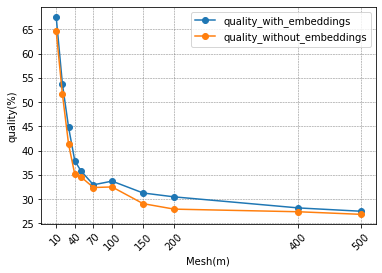

In [4]:
x = df2["maillage"]
y1 = df2["Meilleure_qualite_avec_embeddings"]
y2 = df2["qualite_sans_embeddings_correspondante"]
plt.plot(x, y1, "o-", label="quality_with_embeddings")
plt.plot(x, y2, "o-", label="quality_without_embeddings")
axes = plt.gca()
grid_points = [10, 40, 70, 100, 150, 200, 400, 500]
axes.xaxis.set_ticks(grid_points)
axes.set_xticklabels(grid_points, rotation=45)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
axes.set_xlabel('Mesh(m)')
axes.set_ylabel('quality(%)')
plt.legend()
plt.show()